In [2]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import io

In [3]:
# Define the URL of the zip file
url = 'https://cdn.freecodecamp.org/project-data/books/book-crossings.zip'

# Send the request to download the zip file
headers = {'User-Agent': 'Mozilla/5.0'}
request = urllib.request.Request(url, headers=headers)

# Download and unzip the file in memory
with urllib.request.urlopen(request) as response:
    with zipfile.ZipFile(io.BytesIO(response.read())) as zip_ref:
        zip_ref.extractall()  # Extract all files in the current directory

# Filenames
books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'


# EDA

In [4]:
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [5]:
df_for_cleaning_data = df_ratings.copy()
df_for_cleaning_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   user    1149780 non-null  int32  
 1   isbn    1149780 non-null  object 
 2   rating  1149780 non-null  float32
dtypes: float32(1), int32(1), object(1)
memory usage: 17.5+ MB


In [6]:
df_for_cleaning_data = df_for_cleaning_data.merge(df_books[['isbn', 'title', 'author']], on='isbn', how='left')

In [7]:
df_for_cleaning_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149780 entries, 0 to 1149779
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   user    1149780 non-null  int32  
 1   isbn    1149780 non-null  object 
 2   rating  1149780 non-null  float32
 3   title   1031175 non-null  object 
 4   author  1031174 non-null  object 
dtypes: float32(1), int32(1), object(3)
memory usage: 43.9+ MB


In [8]:
# To ensure statistical significance, remove from the dataset users with less than 200 ratings

#See how many reviews each user has:
user_number_ratings = df_for_cleaning_data['user'].value_counts()
#Filter the users that should be discarded and save their user-ID
users_to_drop = user_number_ratings[user_number_ratings < 200].index


#See how many reviews each book has:
book_number_ratings = df_for_cleaning_data['isbn'].value_counts()

#Filter the users that should be discarded and save their user-ID
books_to_drop = book_number_ratings[book_number_ratings<100].index


#Discard the users that have less than 200 reviews
df_for_cleaning_data.drop(df_for_cleaning_data[df_for_cleaning_data['user'].isin(users_to_drop)].index, inplace=True)

#Discard the books that have less than 100 reviews
df_for_cleaning_data.drop(df_for_cleaning_data[df_for_cleaning_data['isbn'].isin(books_to_drop)].index, inplace=True)

In [9]:
df_for_cleaning_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49781 entries, 1456 to 1147441
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   user    49781 non-null  int32  
 1   isbn    49781 non-null  object 
 2   rating  49781 non-null  float32
 3   title   49517 non-null  object 
 4   author  49517 non-null  object 
dtypes: float32(1), int32(1), object(3)
memory usage: 1.9+ MB


In [10]:
df_for_cleaning_data.reset_index(drop=True, inplace=True)

In [11]:
# Create a final df with the average rating of each book

df_final = df_books

average_rating = df_for_cleaning_data.groupby('isbn')['rating'].mean()

df_final['rating_mean'] = df_final['isbn'].map(average_rating)




In [12]:
# Deleting rows that don't have a title since without title is not possible to know the book
# # Deleting rows that don't have rating_mean or author, since our model will be based on those

df_final.dropna(subset=['title'], inplace=True)
df_final.dropna(subset=['rating_mean'], inplace=True)
df_final.dropna(subset=['author'], inplace=True)

In [13]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727 entries, 18 to 35705
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   isbn         727 non-null    object 
 1   title        727 non-null    object 
 2   author       727 non-null    object 
 3   rating_mean  727 non-null    float32
dtypes: float32(1), object(3)
memory usage: 25.6+ KB


In [14]:
df_final.reset_index(drop=True, inplace=True)

<Figure size 1000x600 with 0 Axes>

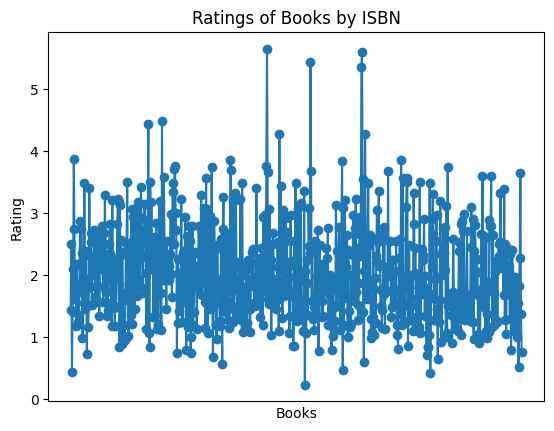

<Figure size 1000x600 with 0 Axes>

In [20]:
# # By curiosity, let's check ig the ratings are similar between different books
plt.plot(df_final['isbn'], df_final['rating_mean'], marker='o')
plt.xlabel('Books')
plt.ylabel('Rating')
plt.title('Ratings of Books by ISBN')
plt.xticks([]) #Hided because there were to many to fit in the image and since they are a code, it was not useful
plt.figure(figsize=(10, 6))

# NearestNeighbors

In [15]:
# Select the columns to pass to the model
X = df_final.drop(columns = ['isbn', 'title'])

In [16]:
# Create a transformer to encode the columns

#Defining columns to transform
categorical_columns = ['author']
numerical_columns = ['rating_mean']

#Define which transformation will be applied to each column
categorical_transformer = OneHotEncoder()
numerical_transformer = StandardScaler()

#Create the preoprocessor to encode the columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns),
        ('num', numerical_transformer, numerical_columns)
    ]
)

X_transformed = preprocessor.fit_transform(X)

In [17]:
nn = NearestNeighbors(n_neighbors=6, algorithm='auto')
nn.fit(X_transformed)

NearestNeighbors(n_neighbors=6)

In [18]:
def get_recommends(book = ""):
  # Retrieve the index of the book
  book_to_search = book
  book_index = df_final[df_final['title'] == book_to_search].index[0]

  # Find the nearest neighbors for the selected book
  distances, indices = nn.kneighbors(X_transformed[book_index])

  recommended_books = [book_to_search, []]

  for i in range(1, len(indices[0])):
    title = df_final.iloc[indices[0][i]]['title']
    distance = distances[0][i]
    recommended_books[1].append([title, distance])

  return recommended_books

In [19]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [['The Honk and Holler Opening Soon', 0.2447846233844757], ['Chicken Soup for the Soul (Chicken Soup for the Soul)', 1.414216155904205], ['Charming Billy', 1.414221068147774], ['Tears of the Moon (Irish Trilogy)', 1.414227982092813], ["What to Expect When You're Expecting (Revised Edition)", 1.4142446118046716]]]
You haven't passed yet. Keep trying!
